<a href="https://colab.research.google.com/github/MalayaRP/Drug-Discovery/blob/main/The_MAMA_AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ls

hERG_dataset.csv  sample_data/  test-hERG.csv  train-hERG.csv


In [ ]:
##installations

%%bash
pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from seaborn import matrix
##required modules
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shap

import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import MCS
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps, IPythonConsole
from IPython.display import SVG
import io
from PIL import Image

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from tensorflow import keras
from keras.layers import *
from keras import Sequential

In [ ]:
def model_performance(real_y, pred_y):

    accuracy = accuracy_score(real_y, pred_y)
    sens = recall_score(real_y, pred_y)
    spec = recall_score(real_y, pred_y, pos_label=0)
    auc = roc_auc_score(real_y, pred_y)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity: {sens:.2f}")
    print(f"Specificity: {spec:.2f}")
    print(f"AUC: {auc:.2f}")

Data Preprocessing & Exploratory Data Analysis

In [ ]:
dataset = pd.read_csv("hERG_dataset.csv")

In [ ]:
dataset["ID"] = [id for id in range(dataset.shape[0])]

In [ ]:
dataset.head(10)

,smiles,activity,ID
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,0
1,Cc1nnc(N2CC[C@@H](F)C2)c2nn(-c3ccc(OCC(F)(F)F)...,1,1
2,O=c1n(Cc2ccccc2)c2sc3c(c2c2ncnn12)CCN(CC1CCOCC...,1,2
3,COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc...,1,3
4,CC1(C)C2=C3C=C4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)...,1,4
5,Fc1ccc(-c2c[nH]c([C@@H]3CCc4[nH]c5ccccc5c4C3)n...,1,5
6,Fc1ccc(-c2c[nH]c([C@H]3Cc4c([nH]c5ccccc45)CN3)...,1,6
7,COc1ccc2ncc(C(F)(F)F)c(CCC34CCC(NCc5ccc6c(n5)N...,1,7
8,Cc1ccccc1CN1[C@H]2CC[C@@H]1C[C@@H](Oc1cccc(C(N...,1,8
9,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc(N4CC...,1,9


In [ ]:
actives = dataset[dataset["activity"]==1]
active_mols = [Chem.MolFromSmiles(s) for s in actives["smiles"]]
inactives = dataset[dataset["activity"]==0]
inactive_mols = [Chem.MolFromSmiles(s) for s in inactives["smiles"]]

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


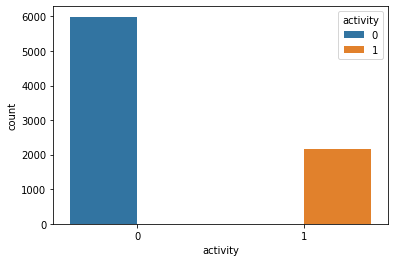

In [ ]:
sns.countplot(dataset["activity"], hue=dataset["activity"])

In [ ]:
## Generate rdkit molecule
mols = [Chem.MolFromSmiles(s) for s in dataset["smiles"]]

In [ ]:
def get_clusters(mols):
  all_morgan_fps = []
  for mol in mols:
    morgan_fps = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
    all_morgan_fps.append(morgan_fps)
  # generate distance matrix
  dist_matrix = []
  num_fps = len(all_morgan_fps)
  for i in range(0, num_fps):
    similarities = DataStructs.BulkTanimotoSimilarity(all_morgan_fps[i],all_morgan_fps[:i])
    dist_matrix.extend([1-x for x in similarities])
  # making cluster
  clusters = Butina.ClusterData(dist_matrix, num_fps, 0.5, isDistData=True) # distance cutoff = 0.5
  return clusters

In [ ]:
active_clusters = get_clusters(active_mols)
inactive_clusters = get_clusters(inactive_mols)

In [ ]:
print("No. of clusters in active class = ", len(active_clusters))
print("No. of clusters in inactive class = ", len(inactive_clusters))

No. of clusters in active class =  770
No. of clusters in inactive class =  2840


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Counts')

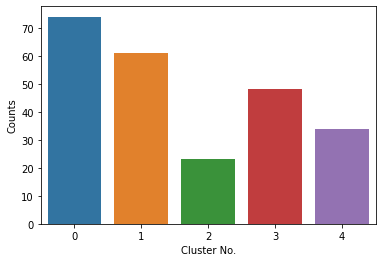

In [ ]:
sns.barplot([x for x in range(5)],[len(c) for c in active_clusters[:5]])
plt.xlabel("Cluster No.")
plt.ylabel("Counts")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Counts')

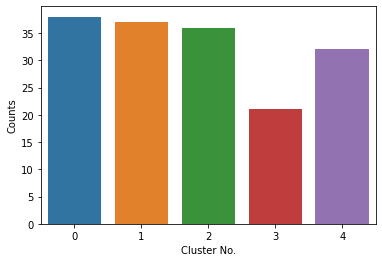

In [ ]:
sns.barplot([x for x in range(5)],[len(c) for c in inactive_clusters[:5]])
plt.xlabel("Cluster No.")
plt.ylabel("Counts")

In [ ]:
# maximum common substructure
def get_common_substruct(clusters,mols):
  mols_from_clusters=[]
  for c in range(len(clusters)):
    mols_list = [mols[i] for i in clusters[c]]
    mols_from_clusters.extend(mols_list)
  mcs = MCS.FindMCS(mols_from_clusters)
  pattern = Chem.MolFromSmarts(mcs.smarts)
  matches = [mol.GetSubstructMatch(pattern) for mol in mols_from_clusters]
  return matches, mols_from_clusters

In [ ]:
active_scaffold, active_mols_from_clusters = get_common_substruct([active_clusters[0]], active_mols)
inactive_scaffold, inactive_mols_from_clusters = get_common_substruct([inactive_clusters[0]], inactive_mols)

The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.


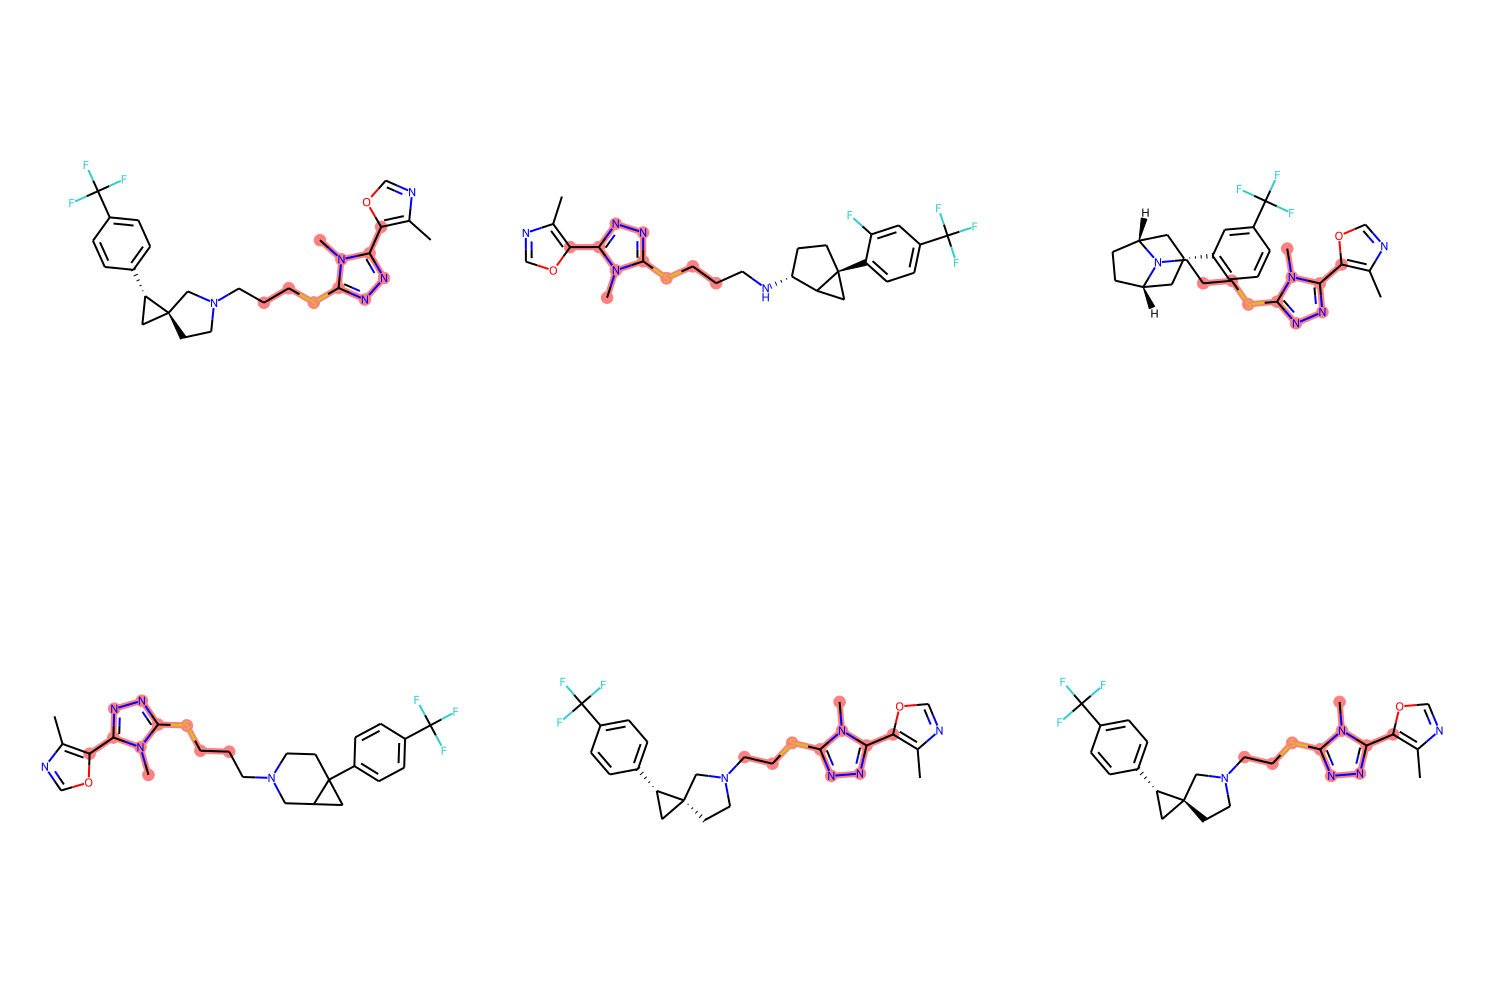

In [ ]:
Draw.MolsToGridImage(active_mols_from_clusters[:6], highlightAtomLists=active_scaffold, molsPerRow=3, subImgSize=(500,500))

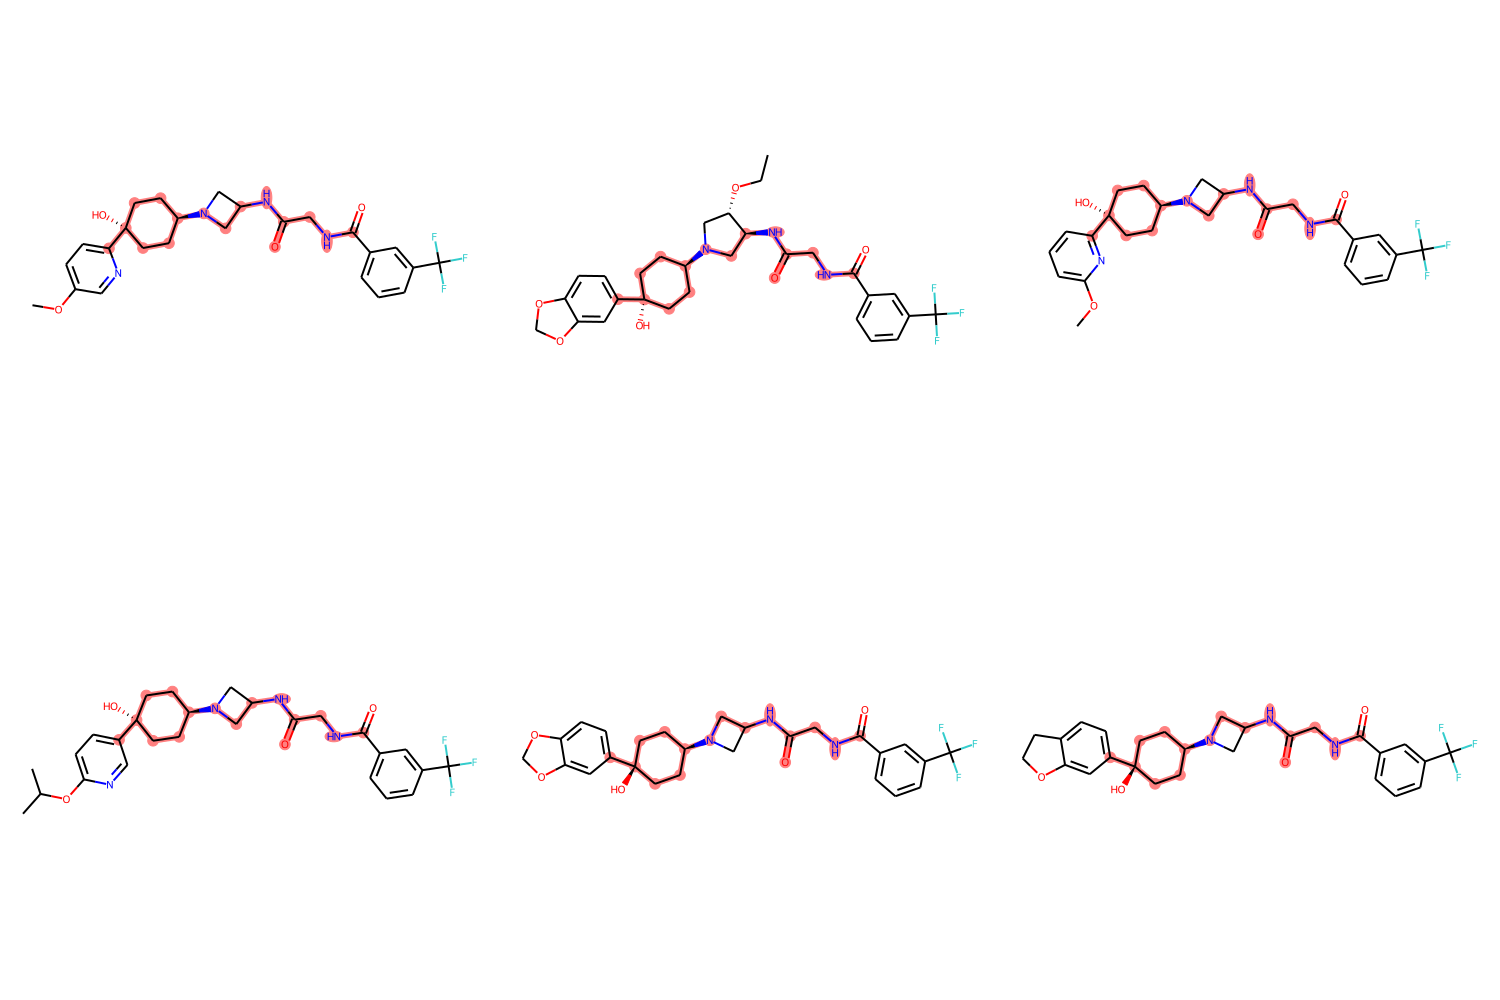

In [ ]:
Draw.MolsToGridImage(inactive_mols_from_clusters[:6], highlightAtomLists=inactive_scaffold, molsPerRow=3, subImgSize=(500,500))

In [ ]:
##identify the dissimilar molecules in the dataset
def get_dissimilar(mols, your_dataset):
  morgan_fps = []
  for mol in mols:
      mfp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
      morgan_fps.append(mfp)
  num_fps = len(morgan_fps)
  dissimilar=[]
  for i in range(0, num_fps):
    similarities = DataStructs.BulkTanimotoSimilarity(morgan_fps[i],morgan_fps[:i])
    if all(similarity < 0.6 for similarity in similarities):
      try:
        dissimilar.append(your_dataset["ID"][i])
      except:
        continue
  return dissimilar

In [ ]:
id_active_dissimilar = get_dissimilar(active_mols, actives)
id_inactive_dissimilar = get_dissimilar(inactive_mols, inactives)

In [ ]:
print(f"Number of dissimilar molecules in active class = {len(id_active_dissimilar)}")
print(f"Number of dissimilar molecules in inactive class = {len(id_inactive_dissimilar)}")

Number of dissimilar molecules in active class = 550
Number of dissimilar molecules in inactive class = 2797


In [ ]:
test_actives = dataset[dataset["ID"].isin(id_active_dissimilar)]
test_inactives = dataset[dataset["ID"].isin(id_inactive_dissimilar)]

In [ ]:
test_inactives

,smiles,activity,ID
1626,CCN(CC)C(=O)c1ccc([C@@H]2CC3(CCNCC3)Oc3ccccc32...,0,1626
1629,OC(c1cccnc1)(c1cccnc1)C(c1ccccc1)N1CCCCC1,0,1629
1642,N[C@H](C(=O)N1CC[C@@H](F)C1)[C@H]1CC[C@H](NS(=...,0,1642
1648,O=C(O)C1CCC2(CCN(c3ccc(-c4nc5cc(C(F)(F)F)ccc5[...,0,1648
1654,COc1ccc(-c2nnc(C(=O)N3CC(Oc4ccc(CN5CCCC56COC6)...,0,1654
...,...,...,...
5981,C[C@H]1C2Cc3ccc(O)cc3[C@]1(C)CCN2CC1CC1,0,5981
5982,Cn1cc(C(F)(F)F)nc1-c1ccc(OCC(O)CNCCOc2ccc(O)c(...,0,5982
5983,OC[C@H]1NC[C@@H](O)[C@@H]1O,0,5983
5988,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0,5988


In [ ]:
test_active_sampled = test_actives.sample(n=100)
test_inactive_sampled = test_inactives.sample(n=100)

In [ ]:
test_inactive_sampled

,smiles,activity,ID
2543,CC(N(C)C)C1(c2ccc(Cl)c(Cl)c2)CCCCC1.Cl,0,2543
4418,Nc1ccc2c(c1)C(=O)c1ccccc1C2=O,0,4418
4207,Nc1ccc(Sc2ccc(N)cc2)cc1,0,4207
4183,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,0,4183
3884,BrCCc1ccccc1,0,3884
...,...,...,...
4579,CCc1ccccc1O,0,4579
5089,CCC(=O)O[C@@](Cc1ccccc1)(c1ccccc1)[C@@H](C)CN(C)C,0,5089
5428,O=C(Nc1ccccc1)c1cc([N+](=O)[O-])ccc1Cl,0,5428
3798,Nc1ccc(-c2ccc(N)c(Cl)c2)cc1Cl,0,3798


In [ ]:
test_dataset = pd.concat([test_active_sampled, test_inactive_sampled], axis=0)

In [ ]:
test_dataset

,smiles,activity,ID
152,CN1C(=O)C=C[C@]2(C)[C@H]3CC[C@@]4(C)[C@@H](CC(...,1,152
1267,Cc1cc(Nc2cc(N[C@@H]3CCCC[C@@H]3N)cnc2C(N)=O)nc...,1,1267
1114,CC(CC(c1ccccc1)c1ccccc1)NC(C)(C)C,1,1114
183,Cc1nc2ccccc2n1[C@@H]1C[C@@H]2CC[C@H](C1)N2CCC1...,1,183
347,Cc1cccc(N2CCN(CCCCCCN3CCN(c4ccnc5ccccc45)CC3)C...,1,347
...,...,...,...
4579,CCc1ccccc1O,0,4579
5089,CCC(=O)O[C@@](Cc1ccccc1)(c1ccccc1)[C@@H](C)CN(C)C,0,5089
5428,O=C(Nc1ccccc1)c1cc([N+](=O)[O-])ccc1Cl,0,5428
3798,Nc1ccc(-c2ccc(N)c(Cl)c2)cc1Cl,0,3798


In [ ]:
train_dataset = dataset.query(f'ID not in {list(test_dataset["ID"])}')

In [ ]:
train_mols = [Chem.MolFromSmiles(s) for s in train_dataset["smiles"]]

In [ ]:
test_mols = [Chem.MolFromSmiles(s)  for s in test_dataset['smiles']]

In [ ]:
def get_features(dataset):
  smiles = dataset.smiles
  mols = [Chem.MolFromSmiles(s) for s in smiles]
  all_fps = []
  bi_all = []
  for mol in mols:
    bi = {}
    morgan_fps = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi)
    all_fps.append(morgan_fps)
    bi_all.append(bi)
  np_fps = np.array(all_fps)
  
  return np_fps, all_fps, bi_all

In [ ]:
train_dataset.to_csv('train-hERG.csv', index=None)
test_dataset.to_csv('test-hERG.csv', index=None)
train_dataset = train_dataset.sample(frac=1)
test_dataset = test_dataset.sample(frac=1)

In [ ]:
train_feats, train_fps, train_bi_all = get_features(train_dataset)

In [ ]:
test_feats, test_fps, test_bi_all = get_features(test_dataset)

In [ ]:
train_df = pd.DataFrame(train_feats)
test_df = pd.DataFrame(test_feats)

In [ ]:
for i in range(len(train_df.columns)):
  train_df.rename(columns={i:f'feature_{i}'}, inplace=True)
for i in range(len(test_df.columns)):
  test_df.rename(columns={i:f'feature_{i}'}, inplace=True)

In [ ]:
train_class = train_dataset.activity.values
test_class = test_dataset.activity.values

Support Vector Classifier

In [ ]:
SVC = svm.SVC(kernel='rbf', probability=True,random_state=42)

In [ ]:
# param_grid = {'C': [1, 10, 100],'gamma': [1, 0.1,],'kernel': ['rbf']}
 
# grid = GridSearchCV(SVC, param_grid, refit = True, verbose = 3)

In [ ]:
# grid.fit(train_feats, train_class)

In [ ]:
# print(grid.best_params_)

In [ ]:
SVC.fit(train_feats, train_class)

SVC(probability=True, random_state=42)

In [ ]:
pred_test_class_svc = SVC.predict(test_feats)
pred_train_class_svc = SVC.predict(train_feats)

Support Vector Classifier Performance

In [ ]:
print('Performance on Train dataset')
model_performance(train_class, pred_train_class_svc)

Performance on Train dataset
Accuracy: 0.95
Sensitivity: 0.85
Specificity: 0.99
AUC: 0.92


In [ ]:
print('Performance on Test dataset')
model_performance(test_class, pred_test_class_svc)

Performance on Test dataset
Accuracy: 0.77
Sensitivity: 0.55
Specificity: 0.99
AUC: 0.77


Support Vector Classifier Cross Validation

In [ ]:
cv_scores_svc = cross_val_score(SVC, train_feats, train_class, cv=5)
cv_scores_svc

array([0.89817725, 0.89314896, 0.90131992, 0.89754871, 0.89245283])

In [ ]:
explainer_svc = shap.KernelExplainer(SVC.predict_proba, shap.sample(train_feats, 100, random_state=42))

In [ ]:
shap_values_svc = explainer_svc.shap_values(shap.sample(test_feats, 5, random_state=42))

In [ ]:
shap.initjs()
shap.force_plot(explainer_svc.expected_value[0], shap_values_svc[0],shap.sample(test_feats, 5, random_state=42) )

Important Features to Predict Active Class


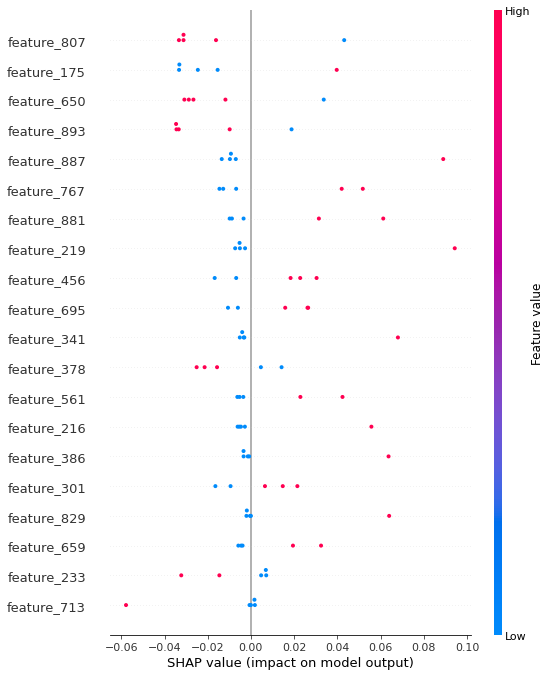

In [ ]:
shap.initjs()
print("Important Features to Predict Active Class")
shap.summary_plot(shap_values_svc[1],shap.sample(test_feats, 5, random_state=42), feature_names=train_df.columns)

Decision Tree Classifier

In [ ]:
DTC = DecisionTreeClassifier(random_state=42) 

In [ ]:
DTC.fit(train_feats, train_class)

DecisionTreeClassifier(random_state=42)

In [ ]:
pred_test_class_dtc = DTC.predict(test_feats)
pred_train_class_dtc = DTC.predict(train_feats)

In [ ]:
print('Performance on Train dataset')
model_performance(train_class, pred_train_class_dtc)

Performance on Train dataset
Accuracy: 1.00
Sensitivity: 0.99
Specificity: 1.00
AUC: 0.99


In [ ]:
print('Performance on Test dataset')
model_performance(test_class, pred_test_class_dtc)

Performance on Test dataset
Accuracy: 0.72
Sensitivity: 0.60
Specificity: 0.85
AUC: 0.73


Decision Tree Classifier Cross Validation

In [ ]:
cv_scores_dtc = cross_val_score(DTC, train_feats, train_class, cv=5)
cv_scores_dtc

array([0.83155248, 0.84726587, 0.84098052, 0.8460088 , 0.82578616])

In [ ]:
explainer_dtc = shap.KernelExplainer(DTC.predict_proba,shap.sample(train_feats, 100, random_state=42) )
shap_values_dtc = explainer_dtc.shap_values(shap.sample(test_feats, 5, random_state=42))

In [ ]:
shap.initjs()
shap.force_plot(explainer_dtc.expected_value[0], shap_values_dtc[0], shap.sample(test_feats, 5, random_state=42))

Important Features to Predict Active Class


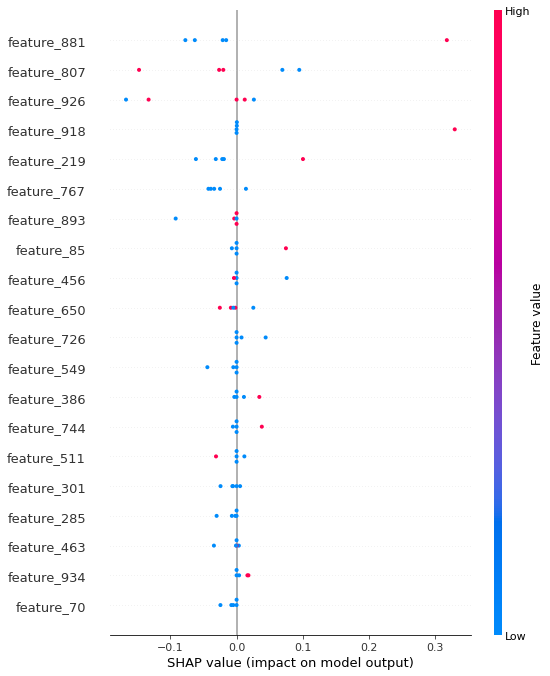

In [ ]:
shap.initjs()
print("Important Features to Predict Active Class")
shap.summary_plot(shap_values_dtc[1],shap.sample(test_feats, 5, random_state=42), feature_names=train_df.columns)

In [ ]:
vals= np.abs(shap_values_dtc).mean(0)

feature_importance = pd.DataFrame(list(zip(test_df.columns, sum(vals))), columns=['feature_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.reset_index(inplace=True)
top10_feats = feature_importance.loc[:9]
all_feats = top10_feats['feature_name'].values

In [ ]:
top10_feats_num = []
for name in all_feats:
  i, j = name.split('_')
  top10_feats_num.append(int(j))

In [ ]:
top10_feats_num

[881, 807, 926, 918, 219, 767, 893, 85, 456, 650]

In [ ]:
top10_feats = feature_importance['feature_name'].values[:10]
top10_feats

array(['feature_881', 'feature_807', 'feature_926', 'feature_918',
       'feature_219', 'feature_767', 'feature_893', 'feature_85',
       'feature_456', 'feature_650'], dtype=object)

In [326]:
prints = []
legend = []
test_indx = []
for feat in top10_feats_num:
  for i in range(len(test_mols)):
    if feat in test_bi_all[i].keys():
      pr = (test_mols[i], feat, test_bi_all[i])
      legend.append(feat)
      test_indx.append(i)
      prints.append(pr)

In [ ]:
test_dataset[test_dataset['ID'].isin(test_indx)]

,smiles,activity,ID
86,O=C1N(CCN2CCC(c3ccc(Cl)cc3)CC2)CCN1c1cccc(Cl)c1,1,86
74,Cc1c(C(=O)N(C)CCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc(-...,1,74
19,O=C(CC1CCN(Cc2ccn(-c3ccc(C(F)(F)F)cc3)c2)CC1)N...,1,19
99,CCCNc1cc(N2CCOCC2)cc(CCc2nc(C)c(CC)o2)n1,1,99
63,Nc1ccnc(N2CCC3(CC2)OC(c2ccccc2)c2ccccc23)c1,1,63
38,COc1ccc([C@H]2CN(CCCC3CCOCC3)C[C@@H]2CC(=O)Nc2...,1,38
28,CN1CCc2c(sc3c2c2ncnn2c(=O)n3Cc2ccc(Cl)cc2)C1,1,28
16,C[C@@H]1CN(CC2(c3ccncc3)CC2)CCN1S(=O)(=O)c1ccc...,1,16
68,Cn1c(SCCCN2CCOC(c3ccc(C(F)(F)F)cc3)C2)nnc1-c1c...,1,68
54,CCCN1C(=O)CC2(CCN(CC3CCN(C(=O)OCC)CC3)CC2)c2cc...,1,54


Visualization of Important Fragments !

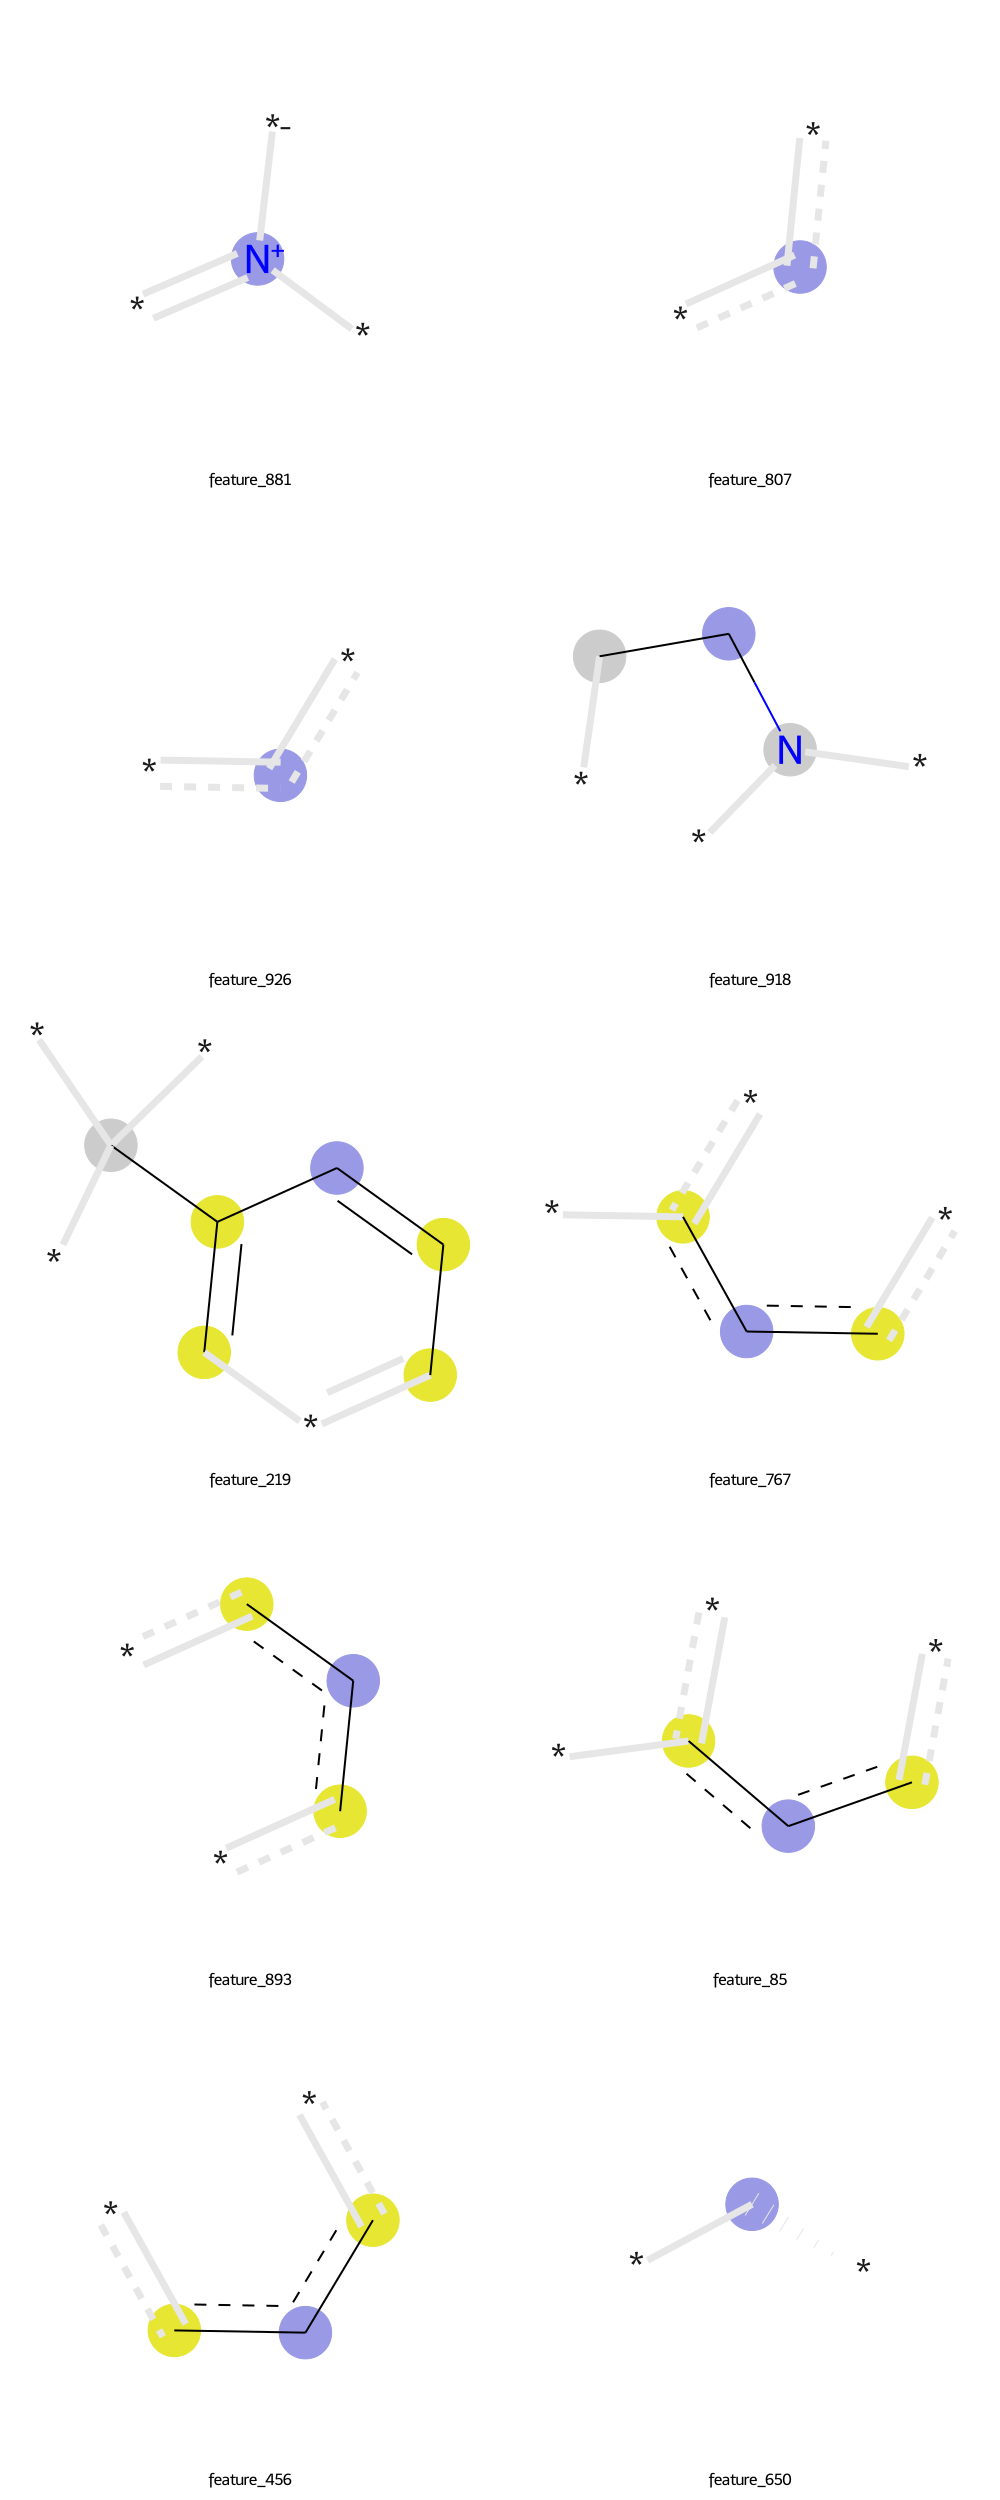

In [ ]:
Draw.DrawMorganBits(prints,subImgSize=(500,500),molsPerRow=2,legends=list(top10_feats))

In [ ]:
valid_dataset = train_dataset.sample(n=200)
train_dataset = train_dataset.query(f'ID not in {list(valid_dataset["ID"])}')
valid_feats, valid_fps, vaid_bi_all = get_features(valid_dataset)
valid_mols = [Chem.MolFromSmiles(s)  for s in valid_dataset['smiles']]
valid_df = pd.DataFrame(valid_feats)
valid_class = valid_dataset.activity.values

for i in range(len(valid_df.columns)):
  valid_df.rename(columns={i:f'feature_{i}'}, inplace=True)

In [ ]:
valid_dataset

,smiles,activity,ID
2756,CS(=O)(=O)c1ccc2c(c1)N(CCN1CCC(NCc3ccc4c(n3)NC...,0,2756
434,CNC(=O)c1c(NCC2CCC3(CCC3)CC2)nc(C#N)nc1OCC1CCN...,1,434
5230,NC(=O)N1c2ccccc2C=Cc2ccccc21,0,5230
2304,CN(C(=O)c1ccc(-n2cccn2)cc1)[C@@H]1CCN(C2CCC2)C1,0,2304
4327,ClC1=C(Cl)C2(Cl)C3C(Cl)C=CC3C1(Cl)C2(Cl)Cl,0,4327
...,...,...,...
708,CCCCCCCN1CCC(C(=O)c2ccccc2)CC1,1,708
7286,NC(=O)[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,0,7286
6415,CN(C)S(=O)(=O)c1ccc2c(c1)/C(=C/c1cc3c([nH]1)CC...,1,6415
2061,O=C(C1CC(Oc2cccc(F)c2)CN1)N1CCCN(C2CCC2)CC1,0,2061


Artificial Neural Network

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=train_feats.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")])

keras.utils.plot_model(model, show_dtype=True, show_shapes=True)
history = model.fit(train_feats, train_class, epochs=100, batch_size=64, validation_data=(valid_feats, valid_class), verbose=2)

Epoch 1/100
125/125 - 3s - loss: 0.5545 - AUC: 0.6388 - val_loss: 0.4108 - val_AUC: 0.9022 - 3s/epoch - 25ms/step
Epoch 2/100
125/125 - 1s - loss: 0.4039 - AUC: 0.8597 - val_loss: 0.2647 - val_AUC: 0.9559 - 1s/epoch - 12ms/step
Epoch 3/100
125/125 - 2s - loss: 0.3296 - AUC: 0.9086 - val_loss: 0.1946 - val_AUC: 0.9808 - 2s/epoch - 12ms/step
Epoch 4/100
125/125 - 2s - loss: 0.2724 - AUC: 0.9373 - val_loss: 0.1403 - val_AUC: 0.9923 - 2s/epoch - 12ms/step
Epoch 5/100
125/125 - 1s - loss: 0.2295 - AUC: 0.9562 - val_loss: 0.1009 - val_AUC: 0.9952 - 1s/epoch - 12ms/step
Epoch 6/100
125/125 - 1s - loss: 0.1857 - AUC: 0.9699 - val_loss: 0.0620 - val_AUC: 0.9994 - 1s/epoch - 12ms/step
Epoch 7/100
125/125 - 2s - loss: 0.1474 - AUC: 0.9812 - val_loss: 0.0513 - val_AUC: 0.9994 - 2s/epoch - 12ms/step
Epoch 8/100
125/125 - 2s - loss: 0.1218 - AUC: 0.9865 - val_loss: 0.0290 - val_AUC: 1.0000 - 2s/epoch - 12ms/step
Epoch 9/100
125/125 - 1s - loss: 0.1078 - AUC: 0.9891 - val_loss: 0.0190 - val_AUC: 1.00

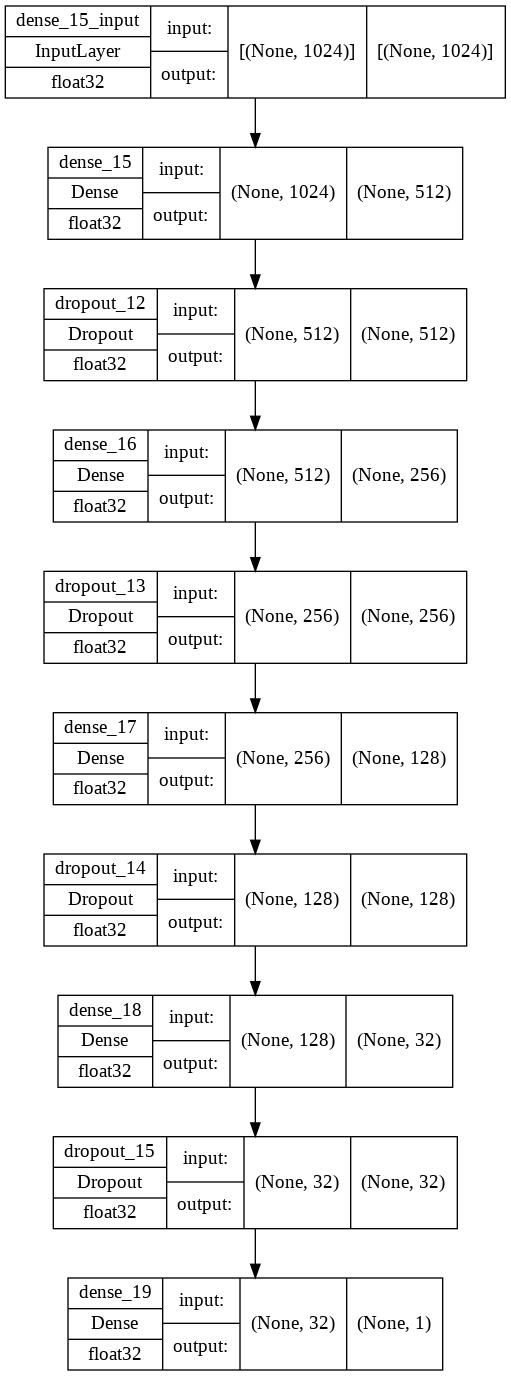

In [ ]:
keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

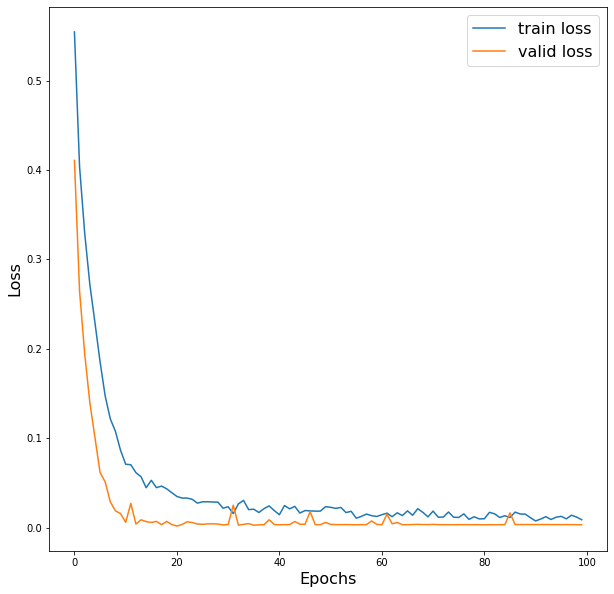

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=16)

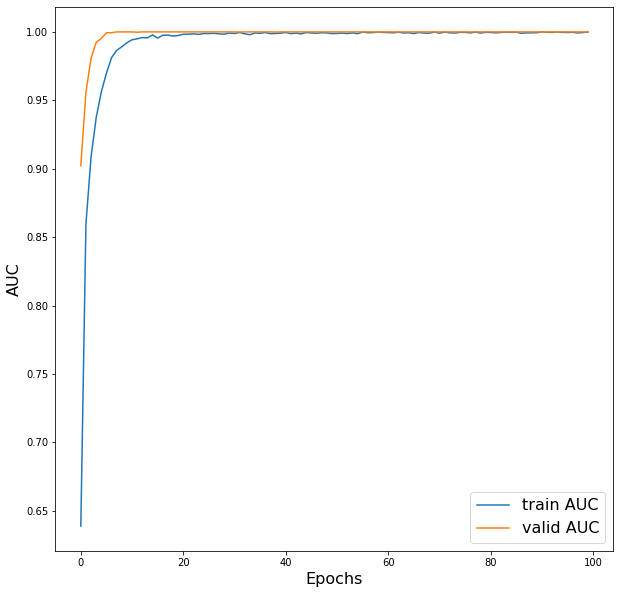

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

In [ ]:
ann_test_pred = model.predict(test_feats)
ann_test_pred_class = np.round(ann_test_pred)
ann_train_pred = model.predict(train_feats)
ann_train_pred_class = np.round(ann_train_pred)

In [ ]:
print('Model performance on train dataset')
model_performance(train_class, ann_train_pred_class)

Model performance on train dataset
Accuracy: 1.00
Sensitivity: 1.00
Specificity: 1.00
AUC: 1.00


In [ ]:
print('Model performance on test dataset')
model_performance(test_class, ann_test_pred_class)

Model performance on test dataset
Accuracy: 0.81
Sensitivity: 0.66
Specificity: 0.96
AUC: 0.81


In [ ]:
explainer = shap.KernelExplainer(model, shap.sample(train_feats, 100, random_state=42))
shap_values = explainer.shap_values(shap.sample(test_feats, 5, random_state=42))

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0])

Important Features to Predict Active Class


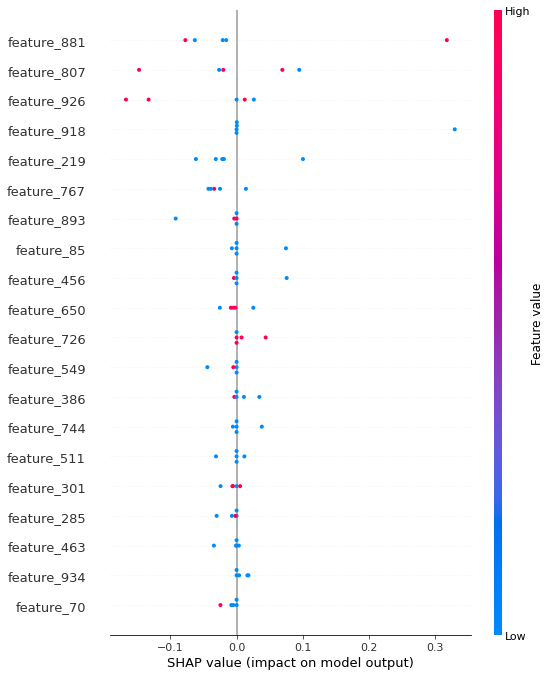

In [ ]:
shap.initjs()
print("Important Features to Predict Active Class")
shap.summary_plot(shap_values_dtc[1],shap.sample(test_feats, 5, random_state=42), feature_names=test_df.columns)

#Conclusion:

          From this analysis I can say that ANN model performs superior as compared to Support Vector Classifier and Decision Tree Classifier, both the accuracy and AUC was observed better on the same test dataset. 